# Chapter 12. Multilevel models

In [85]:
import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3.glm import GLM
import arviz as az
import rethinking
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import theano

In [84]:
plt.rcParams["figure.figsize"] = (20, 10)

## Varying effects model for tadpole survival

In [2]:
df = pd.read_csv("../external/rethinking/data/reedfrogs.csv", sep=";")
print(f"Number of sample {len(df)}")
display(df.head())
df.describe()

Number of sample 48


,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


,density,surv,propsurv
count,48.000000,48.000000,48.000000
mean,23.333333,16.312500,0.721607
std,10.382746,9.884775,0.266416
min,10.000000,4.000000,0.114286
25%,10.000000,9.000000,0.496429
50%,25.000000,12.500000,0.885714
75%,35.000000,23.000000,0.920000
max,35.000000,35.000000,1.000000


In [50]:
models = {}
traces = {}

In [51]:
m = len(df)
n = df.density.values
s = df.surv.values

In [52]:
with pm.Model() as model:
    α_tank = pm.Normal("α_tank", mu=0, sigma=5, shape=m)
    p = pm.math.invlogit(α_tank)
    pm.Binomial("s", n=n, p=p, observed=s) 
models[0] = model 

In [53]:
with pm.Model() as model:
    σ = pm.HalfCauchy("σ", 1)
    α = pm.Normal("α", 0, 1)
    α_tank = pm.Normal("α_tank", mu=α, sigma=σ, shape=m)
    p = pm.math.invlogit(α_tank)
    pm.Binomial("s", n=n, p=p, observed=s)
models[1] = model

In [54]:
kwargs = {"draws": 3000, "tune": 1000, "target_accept": 0.8}
for (i, model) in models.items():
    if i not in traces:
        traces[i] = pm.sample(model=model, **kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_tank]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:06<00:00, 2654.64draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_tank, α, σ]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:05<00:00, 2898.12draws/s]


In [61]:
for (i, trace) in traces.items():
    az.summary(trace).head()

TypeError: object of type 'method' has no len()

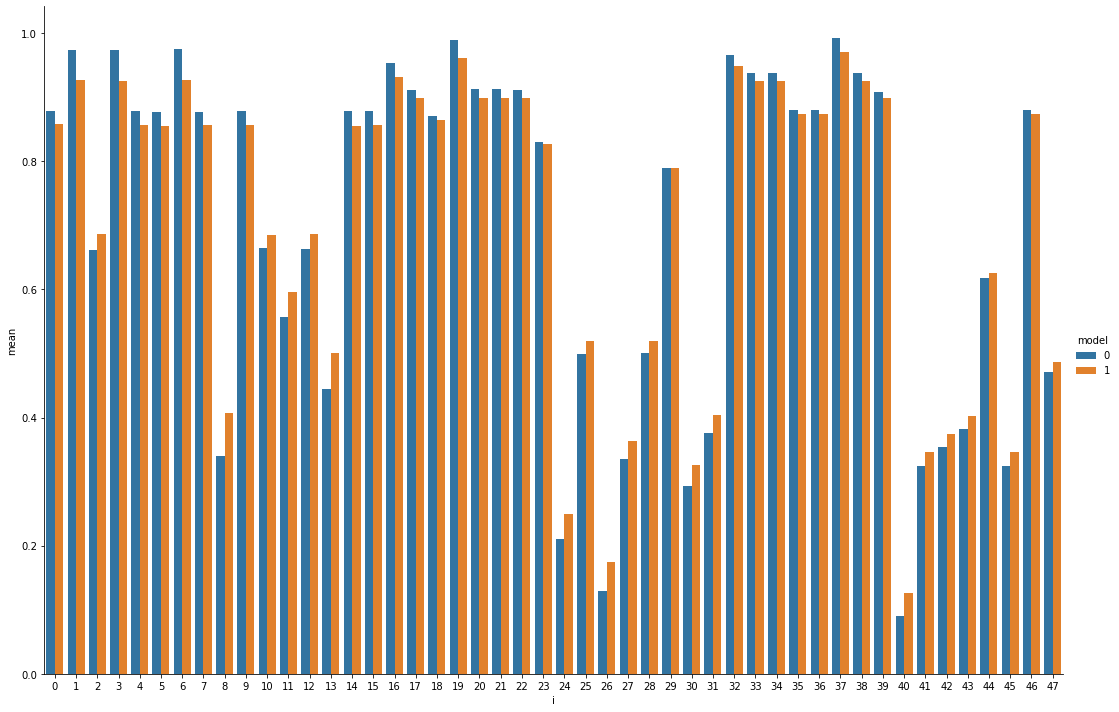

<BarContainer object of 48 artists>

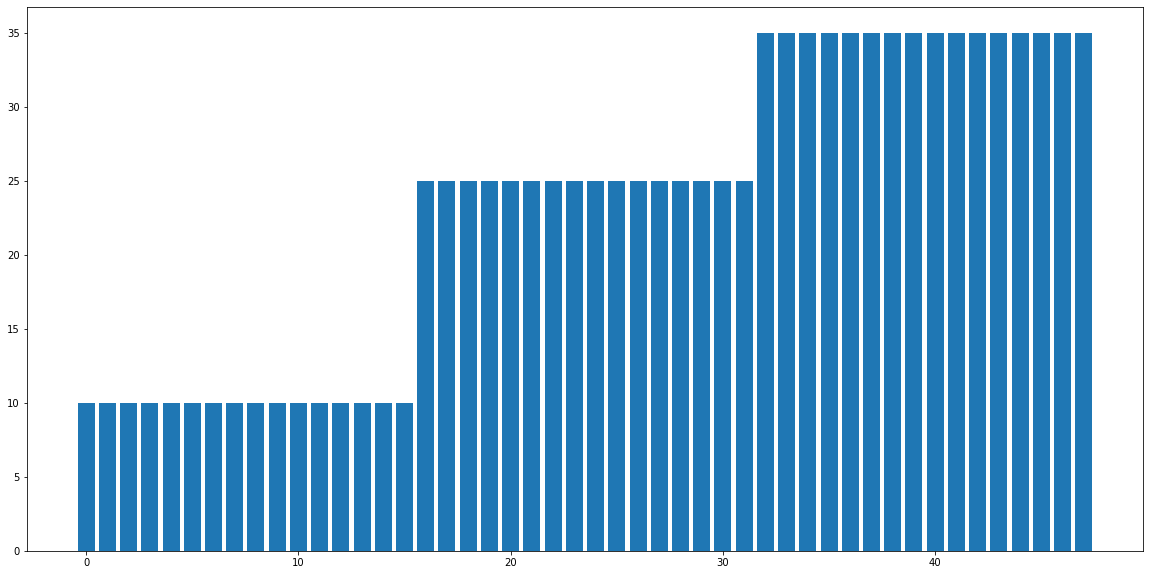

In [98]:
means = {}
for (i, trace) in traces.items():
    means[i] = pd.DataFrame({"i": range(0, m),
                             "mean": (1 / (1 + np.exp(-trace["α_tank"])).mean(axis=0)),
                             "model": i})
sns.catplot(x="i", y="mean", hue="model", height=10, aspect=1.5, data=pd.concat(means.values()), kind="bar")
plt.show()
plt.bar(range(0, len(df)), df.density.values)

In [48]:
rethinking.compare(traces)

/home/bart/.pyenv/versions/anaconda3-5.3.1/envs/statistical-rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1208: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,waic,p_waic,dwaic,weights
1,-100.162489,21.030341,0.000000,0.543212
0,-100.509047,22.445352,0.346558,0.456788


## More than one type of cluster 

In [100]:
df = pd.read_csv("../external/rethinking/data/chimpanzees.csv", sep=";")
display(df.head())
df.describe()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
count,504.000000,252.00000,504.000000,504.000000,504.000000,504.000000,504.00000,504.000000
mean,4.000000,5.00000,0.500000,3.500000,36.500000,0.500000,0.56746,0.579365
std,2.001987,2.00398,0.500497,1.709522,20.803253,0.500497,0.49592,0.494151
min,1.000000,2.00000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000
25%,2.000000,3.00000,0.000000,2.000000,18.750000,0.000000,0.00000,0.000000
50%,4.000000,5.00000,0.500000,3.500000,36.500000,0.500000,1.00000,1.000000
75%,6.000000,7.00000,1.000000,5.000000,54.250000,1.000000,1.00000,1.000000
max,7.000000,8.00000,1.000000,6.000000,72.000000,1.000000,1.00000,1.000000


In [122]:
models = {}
traces = {}

In [133]:
m = len(df)
P = df.prosoc_left.values
C = df.condition.values
L = df.pulled_left.values
A = df.actor.values - 1
B = df.block.values - 1
k_A = len(set(A))
k_B = len(set(B))

In [124]:
with pm.Model() as model:
    σ_actor = pm.HalfCauchy("σ_actor", 1)
    β_PC = pm.Normal("β_PC", 0, 10)
    β_P = pm.Normal("β_P", 0, 10)
    α = pm.Normal("α", 0, 10)
    α_actor = pm.Normal("α_actor", 0, σ_actor, shape=k_A)
    p = pm.math.invlogit(α + α_actor[A] + (β_P + β_PC * C) * P)
    pm.Binomial("L", 1, p, observed=L)
models[0] = model

In [134]:
with pm.Model() as model:
    σ_actor = pm.HalfCauchy("σ_actor", 1)
    σ_block = pm.HalfCauchy("σ_block", 1)
    β_PC = pm.Normal("β_PC", 0, 10)
    β_P = pm.Normal("β_P", 0, 10)
    α = pm.Normal("α", 0, 10)
    α_actor = pm.Normal("α_actor", 0, σ_actor, shape=k_A)
    α_block = pm.Normal("α_block", 0, σ_block, shape=k_B)
    p = pm.math.invlogit(α + α_actor[A] + α_block[B] + (β_P + β_PC * C) * P)
    pm.Binomial("L", 1, p, observed=L)
models[1] = model 

In [135]:
kwargs = {"draws": 2000, "tune": 2000, "target_accept": 0.8}
for (i, model) in models.items():
    if i not in traces:
        traces[i] = pm.sample(model=model, **kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_block, α_actor, α, β_P, β_PC, σ_block, σ_actor]
Sampling 4 chains, 8 divergences: 100%|██████████| 16000/16000 [00:36<00:00, 435.14draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [149]:
for (i, trace) in traces.items():
    display(az.summary(trace))

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
β_PC,-0.134,0.306,-0.765,0.396,0.005,0.003,4167.0,3856.0,4168.0,4548.0,1.0
β_P,0.823,0.268,0.305,1.306,0.004,0.003,3546.0,3546.0,3528.0,4646.0,1.0
α,0.463,0.954,-1.440,2.238,0.029,0.021,1072.0,1072.0,1103.0,1525.0,1.0
α_actor[0],-1.174,0.968,-2.938,0.742,0.029,0.021,1106.0,1101.0,1143.0,1652.0,1.0
α_actor[1],4.229,1.744,1.597,7.431,0.039,0.030,2001.0,1749.0,2403.0,2181.0,1.0
α_actor[2],-1.481,0.975,-3.386,0.301,0.028,0.020,1174.0,1163.0,1206.0,1664.0,1.0
α_actor[3],-1.481,0.972,-3.376,0.324,0.029,0.021,1128.0,1114.0,1159.0,1566.0,1.0
α_actor[4],-1.180,0.971,-3.055,0.690,0.029,0.020,1127.0,1127.0,1160.0,1533.0,1.0
α_actor[5],-0.232,0.971,-2.130,1.588,0.029,0.021,1099.0,1099.0,1133.0,1565.0,1.0
α_actor[6],1.299,0.992,-0.676,3.135,0.029,0.020,1209.0,1209.0,1253.0,1634.0,1.0


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
β_PC,-0.140,0.299,-0.685,0.435,0.004,0.003,5302.0,4067.0,5296.0,4982.0,1.00
β_P,0.832,0.267,0.323,1.323,0.004,0.003,5254.0,4907.0,5246.0,5214.0,1.00
α,0.485,1.007,-1.311,2.453,0.028,0.021,1310.0,1148.0,1366.0,1432.0,1.01
α_actor[0],-1.204,1.007,-3.216,0.606,0.028,0.021,1317.0,1182.0,1378.0,1458.0,1.01
α_actor[1],4.178,1.661,1.469,7.220,0.034,0.025,2430.0,2151.0,2939.0,2424.0,1.00
α_actor[2],-1.514,1.013,-3.425,0.433,0.027,0.021,1370.0,1205.0,1443.0,1421.0,1.01
α_actor[3],-1.511,1.009,-3.527,0.260,0.028,0.021,1306.0,1184.0,1381.0,1455.0,1.01
α_actor[4],-1.204,1.011,-3.292,0.541,0.028,0.021,1295.0,1172.0,1378.0,1478.0,1.01
α_actor[5],-0.259,1.011,-2.264,1.557,0.029,0.021,1225.0,1174.0,1279.0,1495.0,1.01
α_actor[6],1.293,1.026,-0.791,3.139,0.028,0.020,1369.0,1369.0,1411.0,1556.0,1.01


In [151]:
rethinking.compare(traces)

,waic,p_waic,dwaic,weights
0,-265.845575,8.274940,0.000000,0.55343
1,-266.274650,10.361588,0.429075,0.44657


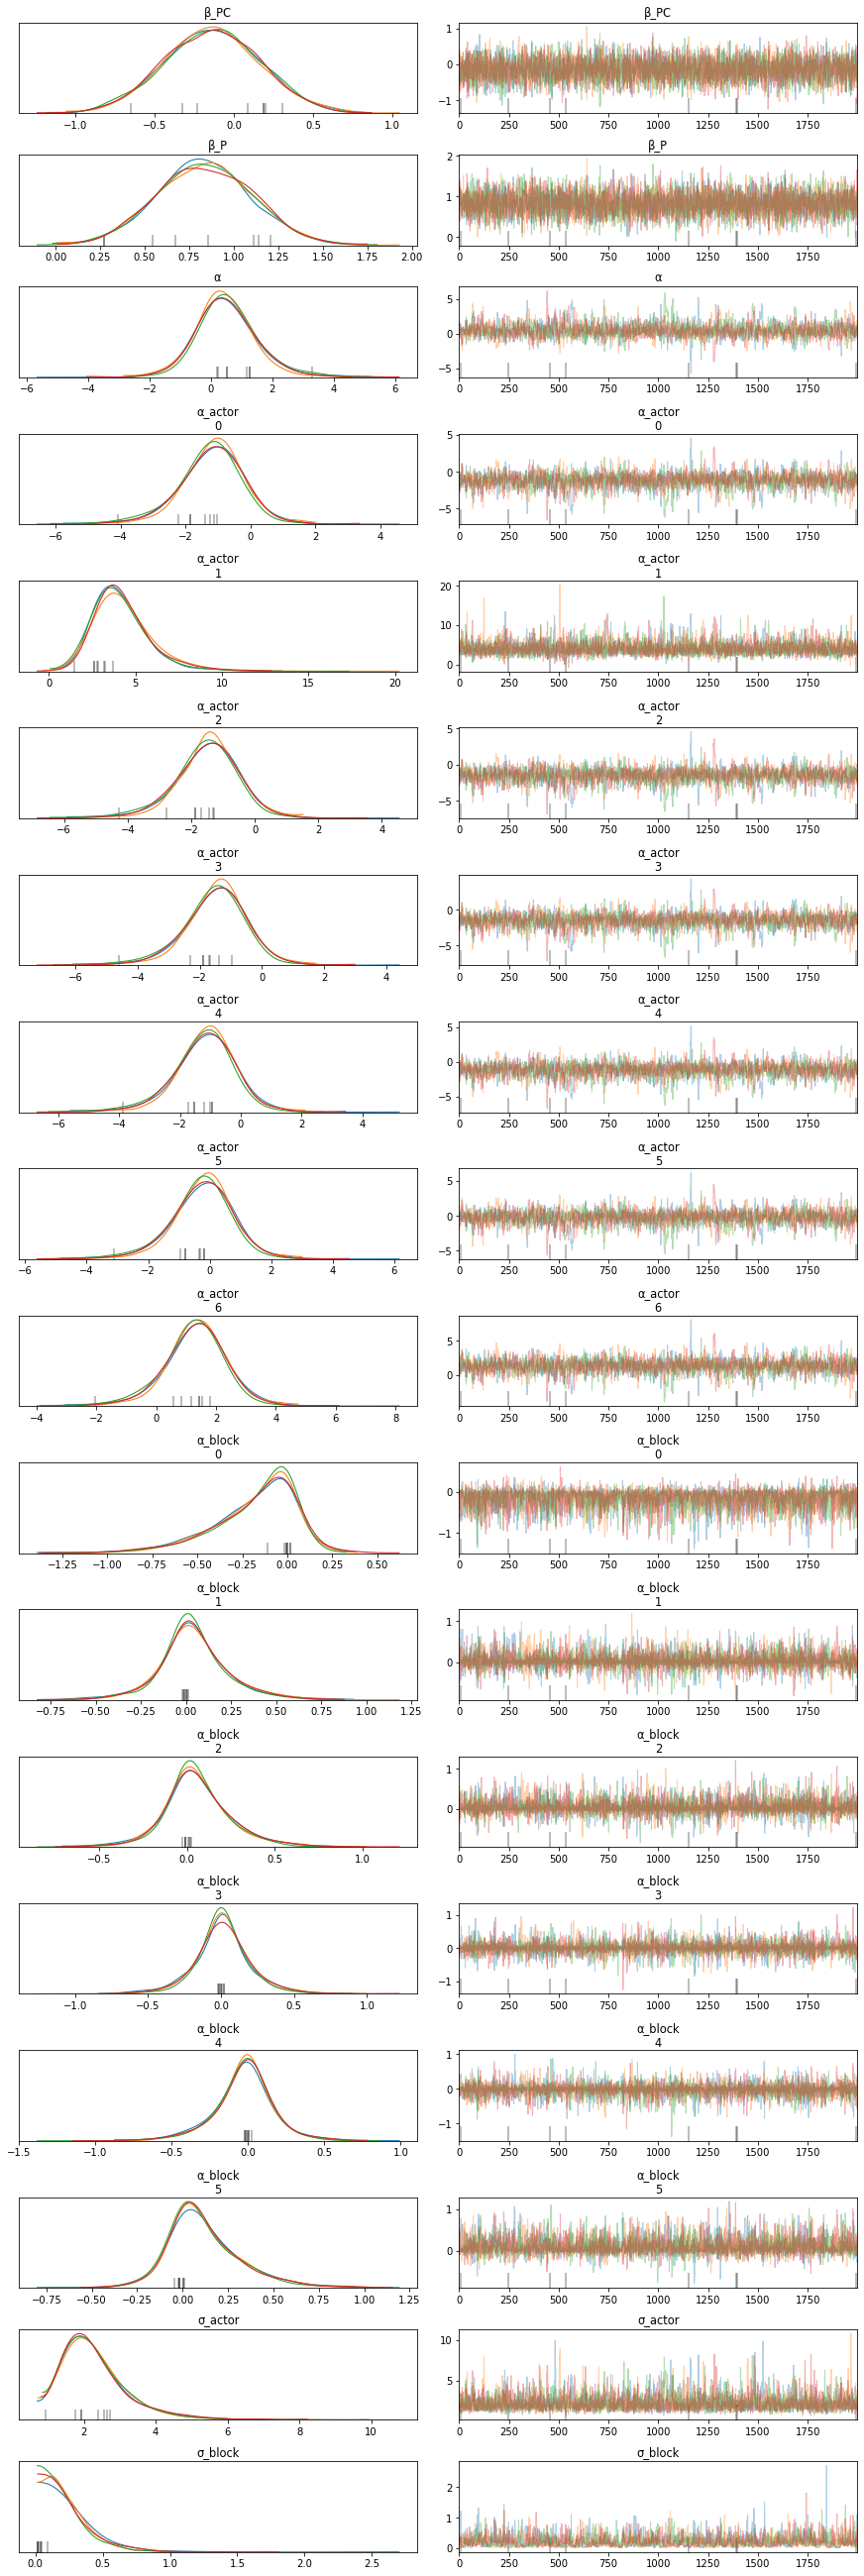

In [136]:
az.plot_trace(traces[1]);

In [132]:
traces[0]["α"].mean() + traces[0]["α_actor"].mean(axis=0)

array([-0.71105809,  4.69152869, -1.01850506, -1.01862151, -0.71694524,
        0.23103631,  1.76212825])